In [ ]:
#modify time 20180820  modify the dropout
import sklearn.metrics
import tensorflow
import sklearn
import keras
import os
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
import pandas as  pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
import pandas as pd
df=pd.DataFrame(pd.read_excel('2018.1-6月1号测风塔数据.xls'))# lack
print(df.columns)

df.columns=['采样时间', '10米风速', '10米风向', '50米风速', '70米风速', '70米风向', '温度', '湿度', '气压']
#df_wind=df.rename({'时间':' 采样时间'})把Excel中原来的“时间”改为“采样时间”
print(df.columns)

# read  real  power
df_real=pd.DataFrame(pd.read_excel('2018.1-6月实际功率.xls'))
print(df_real.columns)
print(df.shape)#测风塔数据有17692行，1+8 列排布
print(df_real.shape)#17692< 18197  so  the  former lack some samples


timefull=pd.date_range('2018-01-01 00:00:00', '2018-07-09 14:45:00', freq= '15min')
timefull=pd.DataFrame(timefull)
timefull.columns=['采样时间']
#timefull.shape
#result = pd.concat([df_real, df], axis=1,ignore_index=True)  #concat the x (features ) and y(real power)
#result=pd.merge(df_real,df,on='采样时间',how='inner')  #
result_1=pd.merge(timefull,df_real,on='采样时间',how='outer')
result=pd.merge(result_1,df,on='采样时间',how='outer')
print(result.shape)

Index(['采样时间', '10米风速', '10米风向', '50米风速', '70米风速', '70米风向', '温度', '湿度', '气压'], dtype='object')
Index(['采样时间', '10米风速', '10米风向', '50米风速', '70米风速', '70米风向', '温度', '湿度', '气压'], dtype='object')
Index(['采样时间', '实际功率（KW)'], dtype='object')
(17692, 9)
(18197, 2)
(18204, 10)


188972.02


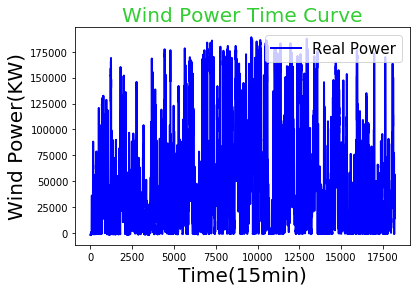

In [4]:
print(max(df_real['实际功率（KW)']))
pyplot.plot(result['实际功率（KW)'],color='blue',linewidth=2)
pyplot.xlabel("Time(15min)",fontsize=20)
pyplot.ylabel("Wind Power(KW)",fontsize=20)
pyplot.title("Wind Power Time Curve",color='limegreen',fontsize=20)
pyplot.legend(labels=['Real Power'],loc='upper right',fontsize=15)
pyplot.show()

In [5]:
import pandas as pd
timefull=pd.date_range('2018-01-01 00:00:00', '2018-07-09 14:45:00', freq= '15min')
timefull.shape

(18204,)

In [6]:
print(result.iloc[440:448])   #15:00   is NaN
#print(result.iloc[446])

                   采样时间  实际功率（KW)  10米风速   10米风向  50米风速  70米风速   70米风向    温度  \
440 2018-01-05 14:00:00  13574.55   6.22  317.96   6.23   4.98  318.34 -7.17   
441 2018-01-05 14:15:00  11431.20   4.68  318.32   4.87   5.41  317.92 -6.61   
442 2018-01-05 14:30:00  11073.97   5.38  317.10   5.63   5.59  317.25 -7.03   
443 2018-01-05 14:45:00  11967.04   5.75  318.47   6.19   5.82  317.83 -7.56   
444 2018-01-05 15:00:00  10359.52    NaN     NaN    NaN    NaN     NaN   NaN   
445 2018-01-05 15:15:00  10716.75   5.44  313.94   5.79   5.43  313.06 -8.12   
446 2018-01-05 15:30:00   8930.62   4.81  310.30   5.34   4.96  311.63 -9.75   
447 2018-01-05 15:45:00  17146.80   6.42  309.40   5.20   5.75  309.96 -9.06   

        湿度      气压  
440  40.11  924.29  
441  38.04  907.85  
442  45.01  948.60  
443  41.64  930.83  
444    NaN     NaN  
445  36.59  905.49  
446  44.52  936.21  
447  39.33  919.29  


In [7]:
print(result.head(6))

                 采样时间  实际功率（KW)  10米风速   10米风向  50米风速  70米风速   70米风向     温度  \
0 2018-01-01 00:00:00  -1607.51   4.41  268.35   5.08   4.32  267.89 -17.66   
1 2018-01-01 00:15:00  -1607.51   5.61  266.71   4.62   4.76  267.47 -16.99   
2 2018-01-01 00:30:00  -1607.51   5.40  266.81   5.69   5.55  266.80 -17.99   
3 2018-01-01 00:45:00  -1607.51   4.86  265.18   4.12   4.26  266.70 -16.65   
4 2018-01-01 01:00:00  -1607.51   4.27  265.96   5.09   4.05  264.02 -17.55   
5 2018-01-01 01:15:00  -1607.51   5.46  262.33   5.54   5.40  262.60 -16.98   

      湿度      气压  
0  40.35  920.77  
1  40.65  920.70  
2  39.84  921.70  
3  43.29  932.55  
4  39.19  916.86  
5  40.64  926.39  


In [8]:
#
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [9]:
# load dataset
dataset = result;
result.head()


,采样时间,实际功率（KW),10米风速,10米风向,50米风速,70米风速,70米风向,温度,湿度,气压
0,2018-01-01 00:00:00,-1607.51,4.41,268.35,5.08,4.32,267.89,-17.66,40.35,920.77
1,2018-01-01 00:15:00,-1607.51,5.61,266.71,4.62,4.76,267.47,-16.99,40.65,920.70
2,2018-01-01 00:30:00,-1607.51,5.40,266.81,5.69,5.55,266.80,-17.99,39.84,921.70
3,2018-01-01 00:45:00,-1607.51,4.86,265.18,4.12,4.26,266.70,-16.65,43.29,932.55
4,2018-01-01 01:00:00,-1607.51,4.27,265.96,5.09,4.05,264.02,-17.55,39.19,916.86


In [10]:
import numpy as np
result_yx=result.drop(columns=['采样时间'])
result_yx=result_yx.replace(0,np.nan)# fill o with  nan
result_yx.head() 
print(result_yx.iloc[408:445]) 

     实际功率（KW)  10米风速   10米风向  50米风速  70米风速   70米风向     温度     湿度      气压
408   -535.84   6.72  318.55   5.86   5.49  317.10 -15.93  42.28  929.98
409   -893.06   6.01  316.92   6.22   6.44  318.00 -15.69  42.58  928.91
410       NaN   5.71  316.02   5.37   6.53  317.32 -15.69  39.53  920.05
411   2857.80   4.99  316.07   5.74   5.05  317.90 -16.02  36.46  900.29
412   5536.99   6.22  316.17   6.42   5.76  316.23 -16.02  44.45  941.27
413   6608.66   6.50  317.53   5.05   6.19  316.81 -15.68  46.91  950.13
414   4286.70   5.30  316.63   6.02   5.99  316.14 -15.48  37.29  911.34
415   4108.09   5.57  319.00   6.48   5.51  318.04 -15.72  38.58  913.27
416   5358.37   5.71  317.10   5.44   5.12  318.36 -15.42  36.63  906.82
417   6251.44   5.99  318.15   6.52   6.47  318.94 -13.87  37.92  906.76
418   7323.11   5.65  316.51   5.16   5.99  316.52 -13.91  41.29  925.36
419   8573.40   4.97  318.61   6.03   5.08  317.85 -13.41  36.41  908.45
420  14646.22   5.16  317.98   5.49   5.12  317.75 

In [11]:
# fill nan with  interpolate
for col in list(result_yx.columns):
    result_yx[col]=result_yx[col].interpolate() 

In [12]:
print(result_yx.iloc[408:445]) 

     实际功率（KW)  10米风速    10米风向  50米风速  70米风速    70米风向     温度      湿度      气压
408   -535.84  6.720  318.550   5.86  5.490  317.100 -15.93  42.280  929.98
409   -893.06  6.010  316.920   6.22  6.440  318.000 -15.69  42.580  928.91
410    982.37  5.710  316.020   5.37  6.530  317.320 -15.69  39.530  920.05
411   2857.80  4.990  316.070   5.74  5.050  317.900 -16.02  36.460  900.29
412   5536.99  6.220  316.170   6.42  5.760  316.230 -16.02  44.450  941.27
413   6608.66  6.500  317.530   5.05  6.190  316.810 -15.68  46.910  950.13
414   4286.70  5.300  316.630   6.02  5.990  316.140 -15.48  37.290  911.34
415   4108.09  5.570  319.000   6.48  5.510  318.040 -15.72  38.580  913.27
416   5358.37  5.710  317.100   5.44  5.120  318.360 -15.42  36.630  906.82
417   6251.44  5.990  318.150   6.52  6.470  318.940 -13.87  37.920  906.76
418   7323.11  5.650  316.510   5.16  5.990  316.520 -13.91  41.290  925.36
419   8573.40  4.970  318.610   6.03  5.080  317.850 -13.41  36.410  908.45
420  14646.2

In [13]:
values = result_yx.values
# ensure all data is float
values = values.astype('float32')
#normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_15min=3
n_feature=9
reframed = series_to_supervised(scaled,n_15min, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.shape)
reframed.columns

(18201, 36)


Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var1(t-2)',
       'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)',
       'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var1(t-1)', 'var2(t-1)',
       'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)',
       'var8(t-1)', 'var9(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)',
       'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)'],
      dtype='object')

In [14]:
# split into train and test sets
n_obs=n_15min*n_feature   #3*9=27
values = reframed.values
#n_train_15min=int(values.shape[0]*0.9991)
train = values[:-160, :]
test = values[-160:, :]
# split into input and outputs
n_obs = n_15min * n_feature

train_X, train_y = train[:, :n_obs], train[:, -n_feature]
test_X, test_y = test[:, :n_obs], test[:, -n_feature]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_15min, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_15min, n_feature))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(values.shape)

(18041, 3, 9) (18041,) (160, 3, 9) (160,)
(18201, 36)


Train on 18041 samples, validate on 160 samples
Epoch 1/188
 - 5s - loss: 0.0838 - val_loss: 0.0683
Epoch 2/188
 - 3s - loss: 0.0626 - val_loss: 0.0663
Epoch 3/188
 - 2s - loss: 0.0610 - val_loss: 0.0664
Epoch 4/188
 - 2s - loss: 0.0575 - val_loss: 0.0576
Epoch 5/188
 - 2s - loss: 0.0524 - val_loss: 0.0618
Epoch 6/188
 - 2s - loss: 0.0500 - val_loss: 0.0619
Epoch 7/188
 - 2s - loss: 0.0488 - val_loss: 0.0464
Epoch 8/188
 - 2s - loss: 0.0485 - val_loss: 0.0565
Epoch 9/188
 - 2s - loss: 0.0490 - val_loss: 0.0459
Epoch 10/188
 - 2s - loss: 0.0487 - val_loss: 0.0469
Epoch 11/188
 - 2s - loss: 0.0484 - val_loss: 0.0620
Epoch 12/188
 - 2s - loss: 0.0490 - val_loss: 0.0565
Epoch 13/188
 - 2s - loss: 0.0476 - val_loss: 0.0481
Epoch 14/188
 - 2s - loss: 0.0488 - val_loss: 0.0488
Epoch 15/188
 - 2s - loss: 0.0490 - val_loss: 0.0605
Epoch 16/188
 - 2s - loss: 0.0505 - val_loss: 0.0588
Epoch 17/188
 - 2s - loss: 0.0468 - val_loss: 0.0541
Epoch 18/188
 - 2s - loss: 0.0481 - val_loss: 0.0583
Epoch 1

Epoch 154/188
 - 2s - loss: 0.0482 - val_loss: 0.0587
Epoch 155/188
 - 3s - loss: 0.0466 - val_loss: 0.0567
Epoch 156/188
 - 2s - loss: 0.0464 - val_loss: 0.0580
Epoch 157/188
 - 2s - loss: 0.0460 - val_loss: 0.0576
Epoch 158/188
 - 2s - loss: 0.0475 - val_loss: 0.0589
Epoch 159/188
 - 2s - loss: 0.0479 - val_loss: 0.0587
Epoch 160/188
 - 2s - loss: 0.0471 - val_loss: 0.0598
Epoch 161/188
 - 3s - loss: 0.0477 - val_loss: 0.0591
Epoch 162/188
 - 3s - loss: 0.0466 - val_loss: 0.0565
Epoch 163/188
 - 3s - loss: 0.0469 - val_loss: 0.0593
Epoch 164/188
 - 2s - loss: 0.0489 - val_loss: 0.0578
Epoch 165/188
 - 2s - loss: 0.0476 - val_loss: 0.0579
Epoch 166/188
 - 2s - loss: 0.0481 - val_loss: 0.0570
Epoch 167/188
 - 2s - loss: 0.0472 - val_loss: 0.0613
Epoch 168/188
 - 3s - loss: 0.0477 - val_loss: 0.0587
Epoch 169/188
 - 3s - loss: 0.0470 - val_loss: 0.0594
Epoch 170/188
 - 4s - loss: 0.0463 - val_loss: 0.0569
Epoch 171/188
 - 3s - loss: 0.0473 - val_loss: 0.0595
Epoch 172/188
 - 3s - loss: 

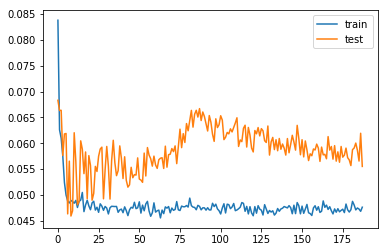

In [15]:
import time
from keras.layers.core import Dense, Activation,Dropout
# design network
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))#全连接
model.add(Dropout(0.09))#when it dropout is 0.09  ,rmsm=13650；按一定概率p随机断开输入神经元，Dropout层用于防止过拟合。
start = time.time()
model.compile(loss='mae', optimizer='adam')
#model.compile(loss='mae', optimizer='rmsprop')
#model.compile(loss='mae', optimizer='Adagrad')
# fit network
history = model.fit(train_X, train_y, epochs=188, batch_size=144, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
print("Compilation Time : ", time.time() - start)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
# make a prediction
yhat = model.predict(test_X) #归一化后，模型下的预测值
test_X = test_X.reshape((test_X.shape[0], n_15min*n_feature))
test_X.shape

(160, 27)

Test RMSE: 13727.532626
Test RMSE Percent: 7.263245
Test MAE: 10592.583008
Test MAPE:5.604541


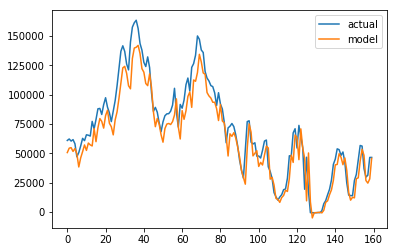

In [17]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -8:]), axis=1) #拼接成yhat，Var2（t-1）-Var9（t-1），期望yhat接近Var1（t）的test部分
inv_yhat = scaler.inverse_transform(inv_yhat) #将整个inv_yhat数据块进行反归一变化，即：将标准化后的数据转换成原来的数据
inv_yhat = inv_yhat[:,0] #取最前面的一列，也就是反归一化后的预测值
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))#重构成一列test_y
inv_y = concatenate((test_y, test_X[:, -8:]), axis=1) #拼接成test_y,Var2（t-1）-Var9（t-1），test_y为归一化后的真实值
inv_y = scaler.inverse_transform(inv_y)   #反归一化，得到原始的真实值
inv_y = inv_y[:,0] #最前面的一列，也就是反归一化后的原始测试值
# calculate RMSE
rmse = sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat))
prmse=rmse/189000*100
mae=sklearn.metrics.mean_absolute_error(inv_y,inv_yhat)
mape=mae/189000*100
from numpy import *
zero_arr = zeros(inv_y.shape)
rmse2 = sqrt(mean_squared_error(zero_arr, inv_yhat))
print('Test RMSE: %.6f' % rmse)
print('Test RMSE Percent: %.6f' % prmse)
print('Test MAE: %.6f'%mae)
print('Test MAPE:%.6f'%mape)
pyplot.plot(inv_y,label='actual')
pyplot.plot(inv_yhat, label='model')
pyplot.legend()
pyplot.show()

In [18]:
import scipy
from scipy import stats
import numpy as np
scipy.stats.pearsonr(inv_y, inv_yhat)

(0.96661574, 2.3995148060199224e-95)

In [19]:
0.65*5

3.25